In [2]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

In [3]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

In [13]:
data = pd.read_csv('20_newsgroup.csv', index_col = 0)
# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-04 10:53:57.085231
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-04 10:53:57.085231
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-04 10:53:57.085231
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-04 10:53:57.085231
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-04 10:53:57.085231


In [14]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
df_train, df_test = train_test_split(data,test_size=0.2,shuffle=True)

In [11]:
! pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

13    794
9     793
7     790
18    607
19    517
Name: target, dtype: int64


C:\Users\javij\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

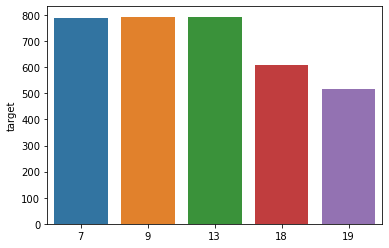

In [21]:
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [18]:
df_train.isna().sum()

text      104
target      0
title       0
date        0
dtype: int64

In [19]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets

nan
nan


In [22]:
df_train = df_train.dropna()

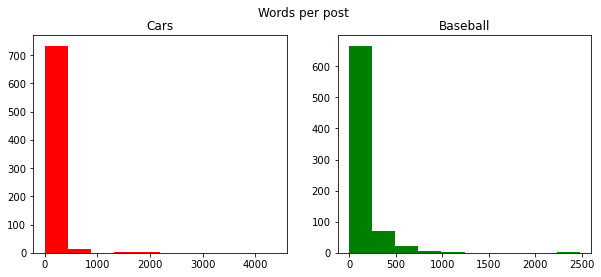

In [25]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Words per post')
plt.show()

In [28]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==7]['char_count'].mean()) # Cars
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball

705.3196286472148
747.1108213820078


In [29]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [30]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,text,target,title,date,word_count,char_count,clean_text
13423,-> >Now let me get this straight. After a ...,18,talk.politics.misc,2022-04-04 10:53:57.085231,301,1764,let get straight nice long rant people need ta...
13722,I am looking for statistics on the prevalence ...,13,sci.med,2022-04-04 10:53:57.085231,115,767,look statistic prevalence disorder treatable b...
2953,"\n\nUnfortunately, Hep B infection can eventua...",13,sci.med,2022-04-04 10:53:57.085231,203,1326,unfortunately hep b infection eventuate chroni...
5960,: >But if entertainment (company) sell compute...,19,talk.religion.misc,2022-04-04 10:53:57.085231,213,1235,entertainment company sell computer program sa...
17385,\n\n\n\nI have been having problems with a sli...,7,rec.autos,2022-04-04 10:53:57.085231,65,362,problem slightly different clutch problem prel...


In [31]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [32]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
def fit(self, X, y):
        return self
def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']]
model = Word2Vec(df_train['clean_text_tok'],min_count=1)    
w2v = dict(zip(model.wv.index_to_key, model.wv.syn0)) 
modelw = MeanEmbeddingVectorizer(w2v)
# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

AttributeError: 'KeyedVectors' object has no attribute 'syn0'

In [33]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, balanced_accuracy_score

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Logistic Regression(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Logistic Regression(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Logistic Regression(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.86      0.94      0.90       158
           9       0.93      0.96      0.94       145
          13       0.93      0.95      0.94       164
          18       0.85      0.79      0.82       118
          19       0.90      0.76      0.82        95

    accuracy                           0.89       680
   macro avg       0.89      0.88      0.88       680
weighted avg       0.89      0.89      0.89       680

Confusion Matrix: [[149   2   3   2   2]
 [  6 139   0   0   0]
 [  6   1 155   2   0]
 [  7   5   7  93   6]
 [  6   3   2  12  72]]
Test Accuracy of Logistic Regression(tf-idf) is 0.8941176470588236 

Test Balanced Accuracy of Logistic Regression(tf-idf) is 0.8785621891241346 

Test F1-score weighted of Logistic Regression(tf-idf) is 0.8925252416312028 



In [34]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Naive Bayes(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Naive Bayes(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.93      0.94      0.93       158
           9       0.82      0.99      0.90       145
          13       0.84      0.96      0.90       164
          18       0.85      0.78      0.81       118
          19       0.96      0.53      0.68        95

    accuracy                           0.87       680
   macro avg       0.88      0.84      0.84       680
weighted avg       0.88      0.87      0.86       680

Confusion Matrix: [[148   7   2   0   1]
 [  2 143   0   0   0]
 [  3   3 157   1   0]
 [  4  10  11  92   1]
 [  3  11  16  15  50]]
Test Accuracy of Naive Bayes(tf-idf) is 0.8676470588235294 

Test Balanced Accuracy of Naive Bayes(tf-idf) is 0.8372419273809573 

Test F1-score weighted of Naive Bayes(tf-idf) is 0.860143026120116 

